<a href="https://colab.research.google.com/github/JAlonMor/Webscraping/blob/main/MODEL_coches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clonar repositorio de GitHub si no está disponible

import os
curr_dir = os.getcwd()

if not os.path.exists(os.path.join(curr_dir, '../.ROOT_DIR')):
  !git clone https://github.com/JAlonMor/Webscraping.git
  os.chdir(os.path.join(curr_dir, 'Webscraping/EDA'))

Cloning into 'Webscraping'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 84 (delta 41), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Amplio límtes de visualización
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

In [3]:
# Creo DataFrame a partir de los datos obtenidos mediante web scraping

model_coches = pd.read_csv("/content/Webscraping/EDA/cochesEDA_Output.csv")

In [4]:
model_coches.head()

,precio,kilometros,garantia,AMG,años,gasolina,hibrido,hib_enchufable,tipo_200,tipo_220,tipo_250,tipo_300,tipo_350,tipo_400,tipo_43,tipo_45,tipo_450,tipo_63,tipo_NoInfo,coupe,berlina,ranchera,4MATIC,Avantgarde,BlueTEC,Sportive,Exclusive,S_Edition,d_Edition
0,16200,281000,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,26900,114336,1,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,11000,287500,0,0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,22900,110000,1,0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,68000,10650,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [7]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = model_coches.values.copy()


y = np.log10(data[:, 0])     # nos quedamos con la 1ª columna, log-price. Importante para juntar más los datos
X = data[:, 1:]      # nos quedamos con el resto

feature_names = model_coches.columns[1:]

(array([  6.,   7.,  32., 192., 630., 582., 304., 115.,  47.,  12.]),
 array([3.87506126, 3.98963269, 4.10420411, 4.21877553, 4.33334695,
        4.44791838, 4.5624898 , 4.67706122, 4.79163264, 4.90620407,
        5.02077549]),
 <a list of 10 Patch objects>)

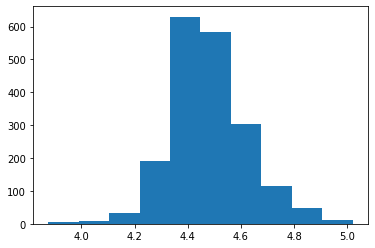

In [12]:
plt.hist(y)

(array([ 61., 657., 732., 283., 107.,  48.,  21.,   7.,   9.,   2.]),
 array([  7500.,  17240.,  26980.,  36720.,  46460.,  56200.,  65940.,
         75680.,  85420.,  95160., 104900.]),
 <a list of 10 Patch objects>)

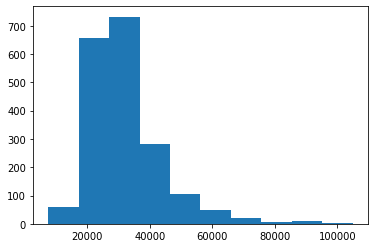

In [13]:
plt.hist(model_coches['precio'])

In [14]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Escalar todos los datos en este punto es INCORRECTO!! 
# X_mal = preprocessing.StandardScaler().fit_transform(X)

# Dividimos los datos en entrenamiento y test (75% training, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Escalamos (obtenemos la transformación con los datos de train y la aplicamos a train y a test). Muy importante escalado
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Datos entrenamiento:  (1445, 28)
Datos test:  (482, 28)


best mean cross-validation score: -0.003
best parameters: {'alpha': 1.8873918221350995e-05}


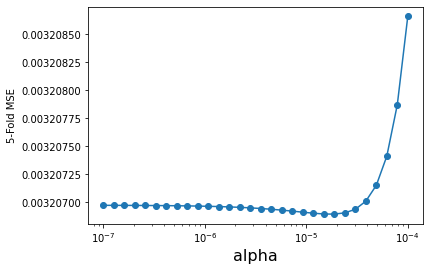

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

K = 5 
alpha_vector = np.logspace(-6, -4, 30)

param_grid = {'alpha': alpha_vector}
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = K)
grid.fit(X_train_scaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector, scores,'-o')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('{}-Fold MSE'.format(K))
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error 

alpha_optimo = grid.best_params_['alpha']

lasso = Lasso(alpha = alpha_optimo).fit(X_train_scaled, y_train)

ytrainLasso = lasso.predict(X_train_scaled)
ytestLasso  = lasso.predict(X_test_scaled)
mseTrainModelLasso = mean_squared_error(y_train, ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test, ytestLasso)

print('alpha: %0.3g' % alpha_optimo)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f, wi in zip(feature_names, w):
    print("{}: {}".format(f, wi))

alpha: 1.89e-05
MSE Modelo Lasso (train): 0.00306
MSE Modelo Lasso (test) : 0.00298
RMSE Modelo Lasso (train): 0.0553
RMSE Modelo Lasso (test) : 0.0546
kilometros: -0.053704086950686104
garantia: 0.008327450530534049
AMG: 0.0157834849014381
años: -0.06442155643857905
gasolina: 0.006894294976300712
hibrido: 0.008068949276855236
hib_enchufable: 0.004285620387798417
tipo_200: 0.005388077115255575
tipo_220: 0.029739610524485784
tipo_250: 0.023362271373193234
tipo_300: 0.017039691198276082
tipo_350: 0.007625805369072641
tipo_400: 0.003845800586301173
tipo_43: 0.030720964895249545
tipo_45: 0.00449998588473598
tipo_450: 0.00850707716010857
tipo_63: 0.06443416347220117
tipo_NoInfo: 0.011863327194954637
coupe: 0.002443082125963864
berlina: -0.022574783689061993
ranchera: -0.029125556487526183
4MATIC: 0.003916292320054617
Avantgarde: 0.0013606577244524637
BlueTEC: 0.004713160164445619
Sportive: -0.0020767966762282376
Exclusive: 0.0018631760333464608
S_Edition: 0.002215288894278618
d_Edition: -0.

Vamos a aumentar el parámetro de regularización y observar los resultados obtenidos:

In [29]:
alpha_optimo = 1e-2
lasso = Lasso(alpha = alpha_optimo).fit(X_train_scaled, y_train)

ytrainLasso = lasso.predict(X_train_scaled)
ytestLasso  = lasso.predict(X_test_scaled)
mseTrainModelLasso = mean_squared_error(y_train, ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test, ytestLasso)

print('alpha: %0.3g' % alpha_optimo)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f, wi in zip(feature_names, w):
    print("{}: {}".format(f, wi))

alpha: 0.01
MSE Modelo Lasso (train): 0.00434
MSE Modelo Lasso (test) : 0.00404
RMSE Modelo Lasso (train): 0.0659
RMSE Modelo Lasso (test) : 0.0635
kilometros: -0.05473288892201121
garantia: 0.0
AMG: 0.013631923295563697
años: -0.051913988763681945
gasolina: 0.007773918601796635
hibrido: 0.0
hib_enchufable: 0.0
tipo_200: -0.004773209847338527
tipo_220: -0.0
tipo_250: 0.0
tipo_300: 0.001521948546126997
tipo_350: 0.0
tipo_400: 0.0
tipo_43: 0.01493711100040455
tipo_45: 0.0
tipo_450: 0.0
tipo_63: 0.04466570292678669
tipo_NoInfo: -0.0
coupe: 0.0
berlina: -0.0005240877817035733
ranchera: -0.00643854604951775
4MATIC: 0.0
Avantgarde: -0.0
BlueTEC: -0.0
Sportive: -0.0
Exclusive: 0.0
S_Edition: 0.0
d_Edition: -0.0


Con este modelo podemos ver las características más valiosas

Puede que tenga Overfitting